# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Breadth-first-Search" data-toc-modified-id="Breadth-first-Search-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Breadth-first Search</a></div><div class="lev3 toc-item"><a href="#Solution" data-toc-modified-id="Solution-101"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>Solution</a></div><div class="lev1 toc-item"><a href="#Depth-first-Search" data-toc-modified-id="Depth-first-Search-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Depth-first Search</a></div><div class="lev3 toc-item"><a href="#Solution" data-toc-modified-id="Solution-201"><span class="toc-item-num">2.0.1&nbsp;&nbsp;</span>Solution</a></div>

In [23]:
import numpy as np
import heapq
from collections import deque
from collections import namedtuple
from IPython import display
import matplotlib.pyplot as plt
from skvideo.io import vwrite
from scipy.ndimage.interpolation import zoom
from matplotlib.colors import ListedColormap

%matplotlib inline

In [38]:
grid_cell_types = ['WALL', 'NORMAL', 'START', 'GOAL', 'FRINGE', 'EXPANDED', 'PATH']
grid_colors = ['black', 'white', 'green', 'red', 'lightblue', 'blue', 'orange']

cmap = ListedColormap(grid_colors)

# don't worry about this part; just for fancy dotted access
GridValues = namedtuple('GridValues', grid_cell_types)
GridValue = namedtuple('GridValue', ['value', 'name', 'color'])
grid_values = GridValues(*[GridValue(i, grid_cell_types[i], grid_colors[i]) for i in range(len(grid_colors))])

In [39]:
def make_grid(size, wall_fraction=0.2, start_goal_locs='corners'):
    size = (size, size) if type(size) == int else size
    
    if start_goal_locs == 'corners':
        start = (0, 0)
        goal = tuple(np.array(size) - 1)
    elif start_goal_locs == 'mid':
        start = (0, 0)
        goal = tuple((np.array(size) / 2).astype(int))
    elif start_goal_locs == 'random':
        assert False
    
    while True:
        maze = np.random.choice([grid_values.WALL.value, grid_values.NORMAL.value], size=size, p=[wall_fraction, 1 - wall_fraction])
        maze[start] = grid_values.START.value
        maze[goal] = grid_values.GOAL.value
        
        # make sure it's solvable
        try:
            bfs_dfs(maze, start, goal, algorithm='dfs')
            break
        except IndexError:
            pass # make a new one and try again
    
    return maze, start, goal

In [40]:
def show_grid(grid):
    plt.figure(figsize=(20, 10))
    img = plt.matshow(grid, cmap=cmap, vmin=-0.5, vmax=len(grid_colors)-0.5, fignum=1)
    cbar = plt.colorbar(ticks=np.arange(0, len(grid_colors)))
    cbar.set_ticklabels(grid_cell_types)


def color_path(grid, path):
    for node in path[1 : -1]: # don't change the start or the goal
        grid[node] = grid_values.PATH.value
    return grid

In [41]:
up = np.array([-1, 0])
down = np.array([1, 0])
left = np.array([0, -1])
right = np.array([0, 1])

def get_neighbors(node_loc, grid):
    upper_bounds = np.array(grid.shape) - 1
    lower_bounds = np.array([0, 0])
    
    neighbors = []
    for direction in [up, down, left, right]:
        neighbor = np.minimum(np.maximum(node_loc + direction, lower_bounds), upper_bounds)
        if not np.all(neighbor == node_loc) and grid[tuple(neighbor)] != grid_values.WALL.value:
            neighbors.append(tuple(neighbor))
    return neighbors

In [42]:
def bfs_dfs(grid, start, goal, algorithm, plot='', video_size=(600, 600), video_path='search.mp4'):
    grid = grid.copy()

    fringe = deque()
    expanded = set() # never expand the same node twice; the first path to any node is the best one
    parents = {} # parent pointer for each node
    current_node = start
    parent = None

    if plot == 'during':
        fig, ax = plt.subplots(figsize=(15, 10))
        img = ax.matshow(grid, cmap=cmap, vmin=-0.5, vmax=len(grid_colors)-0.5)
        cbar = fig.colorbar(img, ticks=np.arange(0, len(grid_colors)))
        cbar.set_ticklabels(grid_cell_types)
    elif plot == 'after':
        zoom_aspect = (video_size[0] / grid.shape[0], video_size[1] / grid.shape[1])
        frames = []

    get_next_node = fringe.pop if algorithm == 'dfs' else fringe.popleft

    while True:
        expanded.add(current_node)
        parents[current_node] = parent
        
        if current_node == goal:
            break

        neighbors = [(neighbor, current_node) for neighbor in get_neighbors(current_node, grid) if neighbor not in expanded]

        if plot:
            if current_node != start:
                maze[current_node] = grid_values.EXPANDED.value
            
            for (neighbor, _) in neighbors:
                if neighbor != goal:
                    maze[neighbor] = grid_values.FRINGE.value
            
            if plot == 'during': # nbagg is faster but it often doesn't leave a graph behind and its window doesn't look as nice
                img.set_data(grid)
                display.display(plt.gcf())
                display.clear_output(wait=True)
            elif plot == 'after':
                frames.append(zoom(grid, zoom_aspect, order=0))

        fringe.extend(neighbors)

        while current_node in expanded:
            current_node, parent = get_next_node()
    
    if plot == 'after':
        frames = np.dstack(frames).transpose(2, 0, 1)
        vwrite(video_path, (cmap(frames) * 255).astype(np.uint8))
    
    # construct path as list of nodes: [start, ..., goal]
    path = [goal]
    parent = parents[goal]
    while parent is not None:
        path.append(parent)
        parent = parents[parent]
    path.reverse() # because we started at the goal
    return path

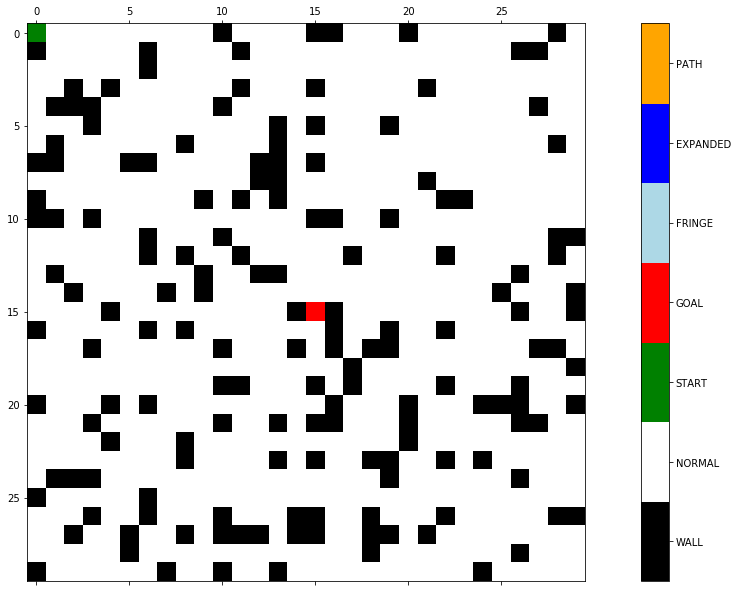

In [43]:
grid, start, goal = make_grid(30, start_goal_locs='mid')
show_grid(grid)

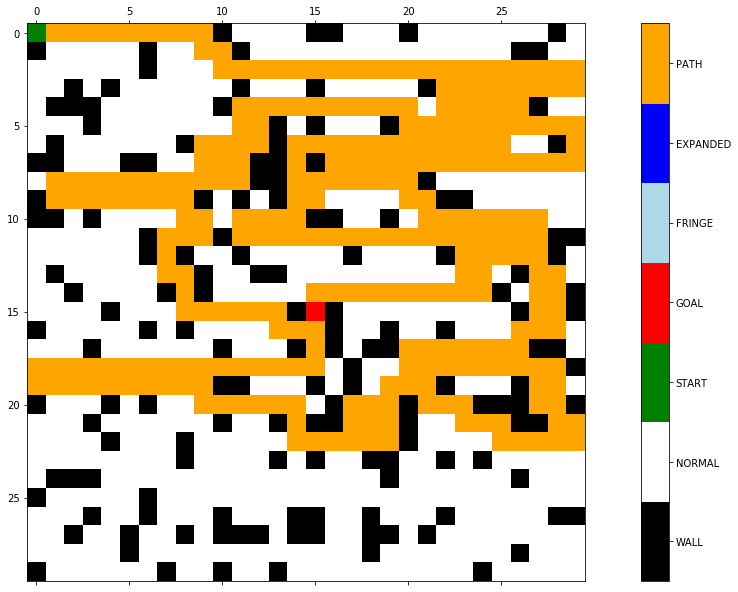

In [44]:
path = bfs_dfs(grid, start, goal, algorithm='dfs')
color_path(grid, path)
show_grid(grid)

<video controls src="dfs.mp4" height='600px' width='600px'/>

<img src='dfs.png'>

<video controls src="dfs_mid.mp4" height='600px' width='600px'/>

<img src="dfs_mid.png">

<video controls src="bfs.mp4" height='600px' width='600px'/>

<img src='bfs.png'>

# Breadth-first Search

Remember that for BFS, you want to start at the source node then search its children, then their children, and so on. Search all nodes at a given level before moving deeper. Think about how you want to store the children so that you can process them in the right order. Also, how will you handle it if you have something like S->A->B->C->A (that is, a node you have already visited is a child of another node you're visiting)? Between nodes at the same level, it doesn't matter what order you handle them in; you can decide.

If you get stuck, I have written a few notes at the start of the solution that you can look at before reading the solution code.

Feel free to use the graph above or make your own; I recommend drawing them first and using that as you write/evaluate your algorithm. During debugging, feel free to use the solution code (with verbose=True if you want more information about what it's doing).

In [2]:
def bfs(start_node):
    pass

In [ ]:
bfs_solution(graph.start_node, verbose=True)

### Solution

For BFS, you can store the nodes you're going to visit in a **Queue**. Think of people in a queue/line to buy tickets: the ones in line the longest get to go through first; for the nodes, those that have been in the queue the longest were added first (because one adds to the end of the queue and removes from the front). For example, if the start node has three children, those will be at the front of the queue; their children will all be in line at the end, and so on.

Some things to note when writing these algorithms:
* Only add a node to the fringe if you haven't visited it before (the **fringe** is a term sometimes used for the structure (e.g. a queue) of nodes which you are going to visit, which should be in order by priority). Because you take paths in order of highest priority, once you visit a node, any other path to it is lower priority.
    * Note, however, that _adding_ a node to the fringe doesn't mean you've visited it yet. You **visit** a node when you _take it off of_ the fringe. Paths may be added to the fringe out of order, but they must be taken off of it in order (by priority).
* Only expand a node if you haven't already visited it (**expanding** means to add the children of a node to the fringe). 
* There are certainly different ways you could construct the path once you find the goal node. I've used a simple example here: I store nodes and the path to them in my fringe. You can't just store the path in the node itself because you may find multiple paths to a given node (you could be careful to only store the highest-priority path to a node, then it should be fine).

In [3]:
def bfs_solution(start_node, verbose=False):
    """
    Returns the path from start_node to the goal_node (discovered using the Node::is_goal function).
    The path is of the form of a list of nodes beginning with start_node and ending with the goal.
    If no path to the goal node is found, an empty list is returned.
    """
    
    fringe = deque([(start_node, [start_node])]) # elements are tuples: (node, path_from_start)
    visited = set() # never visit the same node twice; the first path to any node is the best one
    
    while fringe: # not empty
        node, path = fringe.popleft()
        
        if node in visited:
            continue # already found a better path to this node; ignore this one

        visited.add(node)
            
        if verbose:
            print "Visiting {}; Path is: {}".format(node.name, [path_node.name for path_node in path])
        
        
        if node.is_goal_node():
            if verbose:
                print "Found path: {}".format([path_node.name for path_node in path])
            return path
        else:
            for child in node.get_children():
                if child not in visited:
                    fringe.append((child, path + [child]))
    if verbose:
        print "No path found from {} to goal.".format(start_node)
    return []

SyntaxError: invalid syntax (<ipython-input-3-7204d2ec70c6>, line 20)

# Depth-first Search

Remember that DFS visits nodes further away first. If you can think of a good way to adapt your fringe to keep the nodes in the right order, you shouldn't need to change much from BFS to DFS.

Again, there are some hints/comments at the start of the solution, though they shouldn't matter as much this time.

In [ ]:
bfs_dfs_solution(graph.start_node, 'dfs', verbose=True)

### Solution

You may notice that BFS and DFS are very similar except in how they define priority. For these graph search algorithms, all you have to do to switch between them is change how you keep your paths sorted in the fringe to get them off of it in priority order.
   * However, in practice, sometimes you can gain a bit of a speedup by using a structure that is optimized for your definition of priority instead of one that sorts each element added by your priority definition. You can decide when implementing if it is better to make your function more adaptable or more efficient. That is, a priority queue keeps all elements sorted by a defined priority that each element has. However, instead you can just use a Queue for BFS because it also keeps things in priority-order for BFS (the priority value of each item is just implicit). For DFS, you can use a **Stack** instead of a Queue: think of a stack of books. The first ones you take off are the last ones you added. This means you remove the nodes most recently put on the fringe. For example, if the starting node has three children, those will go to the bottom of the stack. When you expand the top one, its children are added to the top, so you visit those before going back to the two remaining children of the starting node.

To show how similar BFS and DFS are, I wrote a solution function that can do either algorithm with only a very minor change. To write an even more general function, you need to have some aspect of a node that you can use to compute the priorities (e.g. for BFS/DFS, add the distance from the start node and then you can compute the priorities). Then you can use a priority queue that will keep your nodes in the right order for whatever sort of priority you define.

In [ ]:
def bfs_dfs_solution(start_node, search_type, verbose=False):
    """
    Returns the path from start_node to the goal_node (discovered using the Node::is_goal function).
    The path is of the form of a list of nodes beginning with start_node and ending with the goal.
    If no path to the goal node is found, an empty list is returned.
    """
    
    fringe = deque([(start_node, [start_node])]) # elements are tuples: (node, path_from_start)
    visited = set() # never visit the same node twice; the first path to any node is the best one
    
    if search_type == 'bfs':
        get_next_node = fringe.popleft
        add_to_fringe = fringe.append
    elif search_type == 'dfs':
        get_next_node = fringe.pop
        add_to_fringe = fringe.append
    else:
        print "search_type must be bfs or dfs"
        return []
    
    
    while fringe: # not empty
        node, path = get_next_node()
        
        if node in visited:
            continue
        
        visited.add(node)
        
        if verbose:
            print "Visiting {}; Path is: {}".format(node.name, [path_node.name for path_node in path])
            
        if node.is_goal_node():
            if verbose:
                print "Found path: {}".format([path_node.name for path_node in path])
            return path
        else:
            for child in node.get_children():
                if child not in visited:
                    add_to_fringe((child, path + [child]))
    if verbose:
        print "No path found from {} to goal.".format(start_node)
    return []